### Calculating mock magnitudes using Brutus

By default, `speedystar` uses the [MIST](https://waps.cfa.harvard.edu/MIST/) model grids to estimate apparent magnitudes for each star. Alternatively, magnitudes can be calculated using [BRUTUS](https://github.com/joshspeagle/brutus). Brutus uses the MIST models as well, but interpolates them a little more intelligently and should be in general more trustworthy. The mean difference between the Brutus magnitudes and our default magnitudes is ~0.1 mags, and the difference is never more than ~0.4 mags in the most extreme cases. 

In particular, the Brutus magnitudes should in theory be especially more accurate for metal-poor (Z<-0.25) stars (the reasons for this are left to an appendix at the end of this notebook because they are technical and a little boring), but in practice the difference between the Brutus and default magnitudes does not seem to strongly depend on metallicity.

The catch with Brutus is that a little extra legwork is required to get it set up, as it needs to download ~1 Gb of data. It also takes a few minutes to load the model grids when first called after a kernel reset, but afterwards should run just as fast as the default magnitude calculation. 

This notebook will walk you through installing and setting up Brutus, if this extra photometric accuracy (at the expense of extra unruliness) is needed for your science purposes.

### Installation

Do not try to install `Brutus` directly from PyPI -- this version is outdated and will not run because it tries to import depreciated scipy functions. Instead, navigate to the [Brutus Github](https://github.com/joshspeagle/brutus) and download or clone the repository. Navigate to the repository and run `pip install .` or `python setup.py install` to install `Brutus` globally. If this does not work, ensure the `Brutus` folder is in the working directory. 

### Getting started

Let's make a dummy HVS sample first before we use `Brutus` to get magnitudes.

 

In [ ]:
#Import what you need
import numpy as np
import os
from speedystar import starsample
from speedystar.eject import Hills
from speedystar.utils.mwpotential import MWPotential
import astropy.units as u
from galpy import potential
from galpy.potential import MWPotential2014
import mwdust

#Define ejection model and eject some metal-poor stars
HVSmet = -2.0
ejectionmodel = Hills(rate=1e-5/u.yr, Met=HVSmet)

# Eject a small sample of stars from Sgr A*. 
mysample = starsample(ejectionmodel, name='My Hills catalogue')

# Assume a Galactic potential
default_potential = MWPotential2014

#Ensure the potential has physical units so that the final positions and velocities have physical units too. This may or may not be necessary depending on the potential you are using.
potential.turn_physical_on(default_potential)

#Propagate sample
mysample.propagate(potential = default_potential)

#get the unbound stars
inds = np.where(mysample.GCv > mysample.Vesc)[0]
mysample.subsample(inds)

#Uncomment this line and fill out a path if the dust map is located somewhere other than the working directory, or you want it downloaded somewhere other than the working directory
#mysample.config_dust('/path/to/where/you/want/the/dust/map')

#Assign the dust map
mysample.dust = mwdust.Combined15()

In [2]:
#Calculate photometry the default way, for comparison purposes
mysample.photometry()
mysample.save('./cat_photometry_default_'+str(HVSmet)+'.fits')

#Tell Brutus where to download the required model grid files (~1 Gb), or where to find them if they are already downloaded.
mysample.config_brutus(path='./brutus_files_test/')

#Run the photometry with method='brutus'
#This might ~a few - ~ten minutes the first time you run
mysample.photometry(method='brutus')

mysample.save('./cat_photometry_brutus_'+str(HVSmet)+'.fits')

Calculating magnitudes: 100%|██████████| 6/6 [00:25<00:00,  4.31s/it]
Filters: ['Gaia_G_MAW', 'Gaia_BP_MAWf', 'Gaia_RP_MAW', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', 'PS_w', 'PS_open', 'DECam_u', 'DECam_g', 'DECam_r', 'DECam_i', 'DECam_z', 'DECam_Y', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'VISTA_Z', 'VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_Ks', 'UKIDSS_Z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K', 'WISE_W1', 'WISE_W2', 'WISE_W3', 'WISE_W4', 'Tycho_B', 'Tycho_V', 'Hipparcos_Hp', 'Kepler_D51', 'Kepler_Kp', 'TESS']
Constructing MIST library...done!
Computing age weights for track (mini, feh, afe) = (300.0, 0.5, 0.0)            
Initializing FastNN predictor...done!
Calculating magnitudes:: 100%|██████████| 44/44 [00:00<00:00, 49.72it/s]


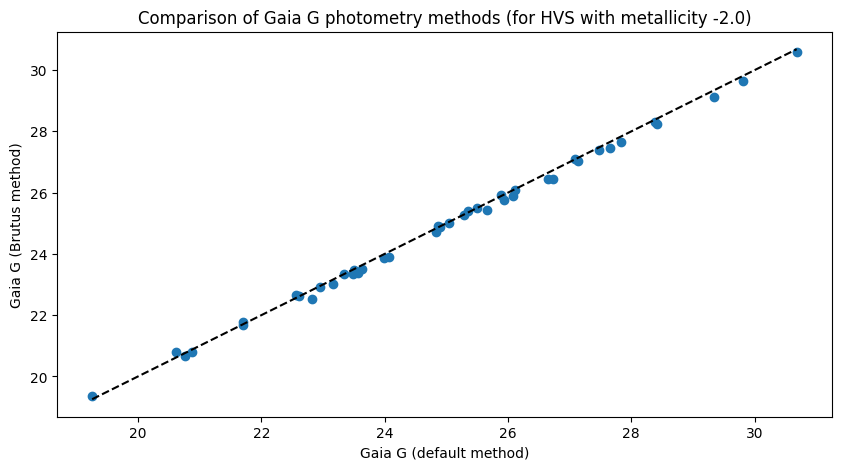

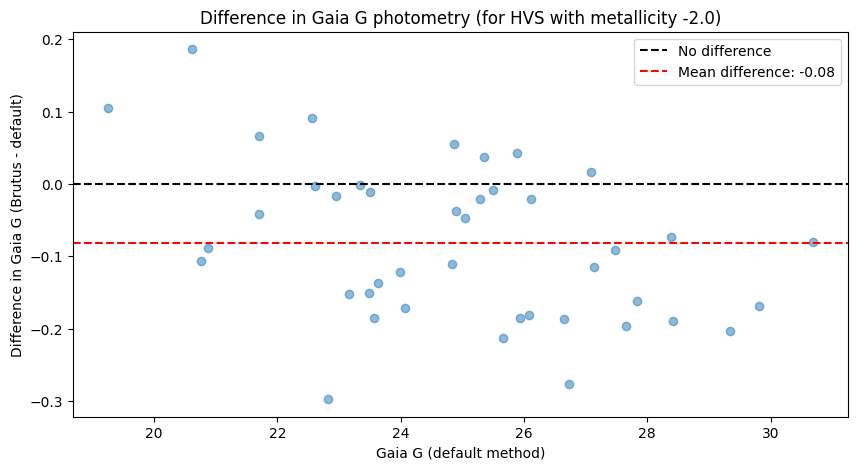

In [4]:
#Plot the difference between the two methods

mysampledefault = starsample('./cat_photometry_default_'+str(HVSmet)+'.fits')
mysamplebrutus = starsample('./cat_photometry_brutus_'+str(HVSmet)+'.fits')

deltaGaiaG = mysamplebrutus.Gaia_G - mysampledefault.Gaia_G

from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(mysampledefault.Gaia_G, mysamplebrutus.Gaia_G)
plt.xlabel('Gaia G (default method)')
plt.ylabel('Gaia G (Brutus method)')
plt.title('Comparison of Gaia G photometry methods (for HVS with metallicity ' + str(HVSmet) + ')')
plt.plot([np.min(mysampledefault.Gaia_G), np.max(mysampledefault.Gaia_G)], [np.min(mysampledefault.Gaia_G), np.max(mysampledefault.Gaia_G)], 'k--', label='1:1 line')
plt.show()

#In a second plot, show the difference in Gaia G magnitudes
plt.figure(figsize=(10, 5))
plt.scatter(mysampledefault.Gaia_G, deltaGaiaG, alpha=0.5)
plt.xlabel('Gaia G (default method)')
plt.ylabel('Difference in Gaia G (Brutus - default)')
plt.title('Difference in Gaia G photometry (for HVS with metallicity ' + str(HVSmet) + ')')
plt.axhline(0, color='k', linestyle='--', label='No difference')
plt.axhline(np.mean(deltaGaiaG), color='r', linestyle='--', label='Mean difference: {:.2f}'.format(np.mean(deltaGaiaG)))
plt.legend()
plt.show()

#Change HVSmet up above and rerun this notebook to see how the comparison changes with metallicity.

### Appendix: Default photometry implementation

By default, `speedystar` calculates apparent magnitudes by interpolating the MIST bolometric correction tables based on the temperature, surface gravity, and line-of-sight dust attenation of each star. These corrections also depend on the metallicity, and MIST provides tables for 23 unique metallicities spanning [Fe/H] = -4 to [Fe/H] = +0.75, where it is assumed that [Fe/H] is the same as the overall metallicity. Including such a wide range of possible metallicities in `speedystar` would bloat the code runtime and size of required files. As such, we made the choice to only include the [Fe/H] = -0.25, [Fe/H] = +0.0, and [Fe/H] = +0.25 correction tables, which is fine for the science case of ejecting HVSs from the Galactic Centre, which is what `speedystar` was originally designed to do. By default, `speedystar` ejection samples have metallicities spanning this range uniformly -- this can be changed using the "Met" (and optionally "metargs") arguments when defining the ejection model, see the documentation. 

Note that at a fixed age and initial mass, the effective temperature and surface gravity of a star does depend quite strongly on the metallicity, and we include metallicity in the calculation of these properties. Once these are accounted for, the difference in magnitude between stars at fixed surface gravity, temperature and dust attenuation, where *only* the metallicity differs, is minimal.